In [1]:
%cd ..

/Users/mateoibarguen/Desktop/genealogy-extraction


In [2]:
from src.relation_models.relation_models import *
from src.wiki_referencer.wiki_reference import WikiReferencer
from src.utils import plot_trees
from itertools import combinations 
import random
import re

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
article_id = '2204744'

In [4]:
model = EntityFeatureRelationModel()

In [5]:
model.persist('nb_model')

In [6]:
wiki_referencer = WikiReferencer()

def predict_relations_article(article_id, wiki_referencer, model):
    article_entities = wiki_referencer.get_article_entities(article_id)
    entities_combinations = list(combinations(article_entities, 2))
    entities_probs = [model.predict_relation_from_ids(article_id=article_id, entity_a_id=e_a, entity_b_id=e_b) for e_a, e_b in entities_combinations]
    entities_probs = [(entities_combinations[i], entities_probs[i]) for i in range(len(entities_combinations))]
    return entities_probs

In [7]:
class ArticleTree:
    def __init__(self, article_id, wiki_referencer, entities_probs):
        self.article_id = article_id
        self.wiki_referencer = wiki_referencer
        self.model = model
        self.article_entities = self.wiki_referencer.get_article_entities(self.article_id)
        self.family_tree = self.initialize_tree(self.article_id)
        self.entities_probs = entities_probs
        self.entities_probs_dict = {comb[0]: comb[1] for comb in self.entities_probs}
        self.relations = ['P26', 'P25', 'P40', 'P22', 'P3373']
        self.relation_maps = {'P22': self.add_father, 
                        'P26': self.add_spouse, 
                        'P25': self.add_mother, 'P3373': self.add_sibling,
                        'P40': self.add_child}
        self.most_prob = self.initialize_most_prob()
        
    def initialize_most_prob(self):
        max_class = [(p[0], p[1], p[1].max()) for p in self.entities_probs]
        max_prob = [(c[0], c[2], c[1].prob(c[2])) for c in max_class]
        return sorted(max_prob, key=lambda x: x[2], reverse=True)
    
    def get_most_prob(self, comb):
        only_one_possible = {'P26', 'P22', '25'}
        possible_relations = self.get_possible_relations(comb[0])
        comb_prob = self.entities_probs_dict[comb]
        possible_relations_prob = [(relation, comb_prob.prob(relation)) for relation in possible_relations]
        return max(possible_relations_prob, key=lambda x: x[1])
        
    def get_possible_relations(self, entity):
        entity_relations = set(self.family_tree[entity].values())
        once_per_entity = {'P25', 'P22', 'P26'}
        many_per_entity = {'P40', 'P3373'}
        possible_relations = once_per_entity - entity_relations
        possible_relations.update(many_per_entity)
        return list(possible_relations)
    
    def updated_probs(self, combs):
        try:
            return max([(comb, self.get_most_prob(comb)) for comb in combs], key=lambda x: x[1][1])
        except:
            return None
        
        
    def initialize_tree(self, article_id):
        family_tree = {}
        for entity in self.article_entities:
            article_entities_c = self.article_entities.copy()
            article_entities_c.remove(entity)
            entity_tree = {entity: {ar_ent: None for ar_ent in article_entities_c}}
            family_tree.update(entity_tree)
        return family_tree
    
    def add_father(self, comb):
        # comb[0] and comb[1] can't have relation.
        # comb[0] can't have father. 

        if 'P22' not in set(self.family_tree[comb[0]].values()):
            if self.family_tree[comb[0]][comb[1]] is None and self.family_tree[comb[1]][comb[0]] is None:
                self.family_tree[comb[0]][comb[1]] = 'P22'
                self.family_tree[comb[1]][comb[0]] = 'P40'
    
    def add_mother(self, comb):
        # comb[0] and comb[1] can't have relation.
        # comb[0] can't have father. 

        if 'P25' not in set(self.family_tree[comb[0]].values()):
            if self.family_tree[comb[0]][comb[1]] is None and self.family_tree[comb[1]][comb[0]] is None:
                self.family_tree[comb[0]][comb[1]] = 'P25'
                self.family_tree[comb[1]][comb[0]] = 'P40'
                
    def add_spouse(self, comb):
        # comb[0] and comb[1] can't have relation.
        # comb[0] can't have father. 

        if 'P26' not in set(self.family_tree[comb[0]].values()):
            if self.family_tree[comb[0]][comb[1]] is None and self.family_tree[comb[1]][comb[0]] is None:
                self.family_tree[comb[0]][comb[1]] = 'P26'
                self.family_tree[comb[1]][comb[0]] = 'P26'
                
                
    def add_sibling(self, comb):
        if self.family_tree[comb[0]][comb[1]] is None and self.family_tree[comb[1]][comb[0]] is None:
                self.family_tree[comb[0]][comb[1]] = 'P3373'
                self.family_tree[comb[1]][comb[0]] = 'P3373'
                
    def add_child(self, comb):
        if self.family_tree[comb[0]][comb[1]] is None and self.family_tree[comb[1]][comb[0]] is None:
                self.family_tree[comb[0]][comb[1]] = 'P40'
                
    def add_relation(self, comb, relation):
        self.relation_maps[relation](comb)
        
    def get_relations(self, threshold_probability):
        combos = list(self.entities_probs_dict.keys())
        added_relations = []
        most_prob_comb = self.most_prob[0]

        while len(combos) > 0:
            relation, relation_prob = self.get_most_prob(most_prob_comb[0])
            if relation_prob > threshold_probability:
                self.add_relation(most_prob_comb[0], relation)
                added_relations.append((most_prob_comb[0], relation))
            combos.remove(most_prob_comb[0])
            most_prob_comb = self.updated_probs(combos)
            
        return added_relations
    
    def get_relations_name(self, threshold_probability=0.3):
        r_map = {'P22': 'father', 'P26': 'spouse', 'P25': 'mother', 'P3373': 'sibling', 'P40': 'child'}
        relations = self.get_relations(threshold_probability)
        relations_names = [(self.wiki_referencer.get_entity_name(ents[0]), 
                            self.wiki_referencer.get_entity_name(ents[1]), r_map[r]) for ents, r in relations]
        return relations_names
    

In [8]:
def get_family_trees(article_id, wiki_referencer, model):
    article_entity_probs = predict_relations_article(article_id, wiki_referencer, model)
    article_tree = ArticleTree(article_id, wiki_referencer, article_entity_probs)
    return article_tree

In [9]:
# article_id = '2204744'



# article_tree = get_family_trees(article_id, wiki_referencer, model)
# article_tree.get_relations_name(threshold_probability=0.5) 

In [10]:
def random_article():
    test_articles = model.test_labels['article_id'].tolist()
    random_article_id = random.sample(test_articles, 1)[0]
    print(wiki_referencer.get_article_text(random_article_id))
    article_tree = get_family_trees(random_article_id, wiki_referencer, model)
    return article_tree

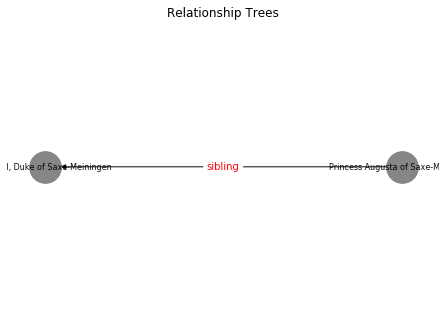

In [40]:
plot_trees(article_tree.get_relations_name(threshold_probability=0.45))

In [11]:
scikit = ScikitEntityFeatureRelationModel(num_train=50)

    entity_a   entity_b article_id relation
0    Q442357    Q108971   29144693      P40
1    Q242825    Q501504    4974687      P40
2    Q155566   Q2562528   19498673      P40
3    Q160770    Q158258     228927      P40
4    Q156400    Q233335    9913432      P25
5       Q939    Q235162      81480    P3373
6    Q232695     Q45068     996208    P3373
7     Q86349     Q71207   21806995      P40
8    Q503991    Q154388     150448      P25
9      Q8409    Q230258        783    P3373
10  Q2435894   Q4089851    6254404      P40
11   Q230507    Q729517     194380      P40
12    Q58037  Q75391286    7537198      P40
13    Q57976     Q57974    7988523      P40
14   Q503991     Q57976     150448      P22
15   Q287503  Q75385285   16824689      P40
16   Q441962    Q169319    4162474      P22
17    Q40234   Q1934546      43616      P40
18   Q232793     Q54054    3842557      P26
19   Q561112   Q1662531     479958    P3373
20    Q64971   Q3847125   27889231      P26
21  Q2599803    Q381082   219547

In [12]:
scikit.persist('svm_03')

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DictVectorizer from version 0.21.3 when using version 0.21.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.3 when using version 0.21.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [13]:
probs = scikit.predict_relation_from_ids(article_id='2020952', entity_a_id='Q2259', entity_b_id='Q229413')

processing_relationship...


In [15]:
from nltk.probability import DictionaryProbDist as D

In [16]:
D(probs)

<ProbDist with 5 samples>

In [ ]:
save_model(scikit.classifier, 'svm_01')

In [ ]:
def check_entiy_mentioned(entity_id, article_id):
    article_tagged = wiki_referencer.get_article_tags(article_id)
    check = re.search(f'@{entity_id}@', article_tagged)
    if check:
        return True
    return False